# xPSG : Sports Analytics Challenge
This notebook presents excerpts of code used in the 2019 xPSG Sports Analytics Challenge. During the challenge, I had access to better computational resources: the version presented here is thus a 'lite' version of what I used. I did not qualify for the final round, but I still wanted to share insights learned during the process. A blog article about this experience can be read here: https://medium.com/@jeremi.debloisbeaucage/la-science-des-donn%C3%A9es-appliqu%C3%A9e-au-soccer-le-challenge-xpsg-2f35d8c4f940.

The task presented in this code is to predict which team will do the next event, using the preceding 10 events. An event can be anything related to soccer: a pass, shot, dribble, center, etc. and can be characterized by numerous qualifiers (long pass, chipped pass, etc.) Deep learning is used, via a Long Short-Memory (LSTM) Recurrent Neural Network (RNN).

This code has 3 different sections:
1. Extracting, cleaning and observing datasets
2. Creating training, validation and test sets
3. Training models and choosing the best

# 1. Extracting, cleaning and observing datasets


## 1.1 Clean players dataset
We have a xml file and we want a clean dataset, with players id, name, position and team.

In [38]:
import csv
import xml.etree.ElementTree as et
import numpy as np
import pandas as pd
from datetime import datetime as dt

In [39]:
filepath = "instructions/Noms des joueurs et IDs - F40 - L1 20162017.xml"
tree = et.ElementTree(file = filepath)
gameFile = tree.getroot()

player_id = []
player_name = []
player_pos = []
player_team = []
player_team_id = []
player_real_pos = []
player_real_pos_side = []

#Iterate through each document in our file - we only have one
for SoccerDocument in gameFile: 
    #Iterate through each team in the document
    for Team in SoccerDocument:
        for Player in Team:
            if Player.tag =='Player':
                player_id.append(Player.attrib.get("uID"))
                player_team.append(Team.attrib.get("short_club_name"))
                player_team_id.append(Team.attrib.get("uID"))
                for Element in Player:
                    if Element.tag == 'Name':
                        player_name.append(Element.text)
                    if Element.tag == 'Position':
                        player_pos.append(Element.text)
                    if Element.tag == 'Stat':
                        if Element.attrib.get('Type') == 'real_position':
                            player_real_pos.append(Element.text)
                        if Element.attrib.get('Type') == 'real_position_side':
                                player_real_pos_side.append(Element.text)


df = pd.DataFrame(player_id)
df['name'] = player_name
df['position'] = player_pos
df['player_real_pos'] = player_real_pos 
df['player_real_pos_side'] = player_real_pos_side
df['club'] = player_team
df['club_id'] = player_team_id


df.columns = ['id', 'name', 'position', 'real_pos', 'side', 'club', 'club_id']

df['id'] = df['id'].map(lambda x: str(x)[1:])
df['club_id'] = df['club_id'].map(lambda x: str(x)[1:])
df['id'] = df['id'].astype('float64') 
df['club_id'] = df['club_id'].astype('float64') 


df['full_pos'] = df['position'] + df['real_pos'] + df['side']
df['position_side'] = df['position'] + df['side']


### Explore players dataset

In [40]:
df.club.value_counts()

Monaco           47
Saint-Étienne    40
Metz             39
Lille            38
Rennes           38
Bordeaux         37
Lorient          37
Marseille        37
Paris SG         37
Nice             35
Toulouse         35
Angers           35
Caen             34
Lyon             33
Bastia           33
Dijon            32
Guingamp         32
Montpellier      31
Nantes           29
Nancy            29
Name: club, dtype: int64

In [42]:
df.real_pos.value_counts()

Central Defender        107
Full Back               101
Striker                  85
Central Midfielder       76
Goalkeeper               73
Unknown                  73
Attacking Midfielder     64
Winger                   62
Defensive Midfielder     50
Second Striker           12
Wing Back                 5
Name: real_pos, dtype: int64

## 1.2 Clean events dataset
We have raw xml files, that we want to transform as clean csv files.

We used a R code found online. Here are the cleaned datasets.

In [43]:
filepath = 'data/clean/853166.csv'
df = pd.read_csv(filepath)
df.sort_values(['min', 'sec'], inplace=True)
df.fillna(0, inplace=True)
df

,Unnamed: 0,id,event_id,type_id,period_id,min,sec,team_id,outcome,x,...,75,76,77,80,82,83,84,88,9,94
42,43,1042922,2,32,1,0,0,149,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213,214,1230845402,1,34,16,0,0,149,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
459,460,1526891712,1,34,16,0,0,146,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
484,485,1556442165,701,37,14,0,0,146,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
557,558,1625181323,1031,37,14,0,0,149,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,276,130154755,1026,1,2,92,24,149,1,25.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1059,1060,240758252,1027,1,2,92,28,149,1,34.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
545,546,1612944515,1028,1,2,92,29,149,1,40.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1475,1476,693012064,699,30,2,92,32,146,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Explore one specific game: PSG goal against Monaco

In [45]:
example = df[['min','sec','type_id','outcome','team_id','x','y','player_id','15','154','155','3','80']][df['min'] == 62]
example = example[(example.index != 1601) & (example.index != 1745)]
example

,min,sec,type_id,outcome,team_id,x,y,player_id,15,154,155,3,80
10,62,49,44,1,428,30.3,70.0,67100.0,NaN,NaN,NaN,NaN,NaN
17,62,28,43,1,428,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
23,62,42,1,1,145,25.2,60.7,108988.0,NaN,NaN,NaN,NaN,NaN
338,62,46,1,0,145,11.8,36.6,83280.0,NaN,NaN,NaN,NaN,NaN
494,62,55,1,0,428,45.0,95.1,27675.0,NaN,NaN,NaN,NaN,NaN
715,62,55,74,1,145,56.4,10.1,80800.0,NaN,NaN,NaN,NaN,NaN
743,62,38,1,1,145,32.3,0.0,80800.0,NaN,NaN,NaN,NaN,NaN
915,62,49,44,0,145,66.5,28.9,111315.0,NaN,NaN,NaN,NaN,NaN
973,62,41,1,1,145,27.1,26.4,133633.0,NaN,NaN,NaN,NaN,NaN
1171,62,24,19,1,428,0.0,0.0,54533.0,NaN,NaN,NaN,NaN,NaN


### Get stats about the games
Number of games, number of events per game, and number of different unique events

In [44]:
unique_events = []
events = 0
games = 0
for extension in range(853139, 853329, 1):
    df = pd.read_csv('data/clean/' + str(extension) + '.csv')
    events += df.shape[0]
    games += 1
    event_list = df.type_id.unique().tolist()
    for event in event_list:
        if event not in unique_events:
            unique_events.append(event)
            
print(games)
print(events)
print(events/games)
print(len(unique_events))

190
335429
1765.4157894736843
50


# 2. Creating train, validation and test sets
We have 3 tasks. We will focus on predicting who will do the next event, with the last 10 events.

What to keep in the datasets?
- Type_id
- timestamp
- outcome
- x,y
- team
- qualifiers: 1,2,3,5,155 (arbitrary choice of what looked important)

In [1]:
import csv
import xml.etree.ElementTree as et
import numpy as np
import pandas as pd
from datetime import datetime as dt

from numpy import array

In [5]:
#all the columns that will be in the final datasets
with open('final_columns.txt', 'r') as filehandle:  
    for line in filehandle:
        currentPlace = line[:-1]
        # remove linebreak which is the last character of the string
        col_names = currentPlace.split(',')

In [10]:
d_x={}
d_y={}

#for extension in range(853139, 853262, 1): #TRAINING SET
#for extension in range(853262, 853300, 1): #TEST SET
for extension in range(853300, 853329, 1):  #VALIDATION SET

    df = pd.read_csv('data/clean/' + str(extension) + '.csv')

    #only keep chosen columns
    chosen = ['timestamp', 'type_id', 'outcome', 'team_id', 'x', 'y','1','2','3','5','155']
    df = df[chosen]

    #make sure that the events are ordered in time
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by='timestamp') 

    #replace the team ids with 0 and 1
    team_1 = df.team_id.unique()[0]
    df['team'] = (df.team_id == team_1).astype(int)

    #drop old team_id and timestamp, not useful
    df.drop(['team_id', 'timestamp'], axis=1, inplace=True)

    #transform type_id into categorical
    df = pd.get_dummies(df, columns=['type_id'])

    #add columns for event that were not in this game, and assign them a value of 0 
    df_col = list(df)
    for col in col_names:
        if not col in df_col:
            df[col] = 0

    #add target, which is the team for the next event
    df['target'] = df['team'].shift(-1)

    #fill all NaN with 0, so all qualifiers and the last target
    df.fillna(0, inplace=True)

    #working with numpy
    np_values = df.values

    
    def split_sequences(sequences, n_steps):
        X, y = list(), list()
        for i in range(len(sequences)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the dataset
            if end_ix > len(sequences):
                break
            # x: get all columns except last one, for all rows from i to end_ix
            # y: get only last column, for the last row end_ix
            seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
            X.append(seq_x)
            y.append(seq_y)
        return array(X), array(y)

    n_steps = 10

    d_x["one_{0}".format(extension)], d_y["one_{0}".format(extension)] = split_sequences(np_values, n_steps)

X = np.concatenate([d_x[x] for x in d_x])
y = np.concatenate([d_y[x] for x in d_y])

#%%
np.save("article/x_val", X)
np.save("article/y_val", y)

# 3. Training models and choosing the best

## 3.1 Models with outcome and qualifiers
xPSG censured some data to add a technical difficulty. The first model presented here takes all data, even the censured one.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, concatenate
from keras.utils.np_utils import to_categorical
from keras.layers.wrappers import Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

seed = 92

Using TensorFlow backend.


### Load datasets

In [2]:
X_train = np.load('article/x_train.npy')
y_train = np.load('article/y_train.npy')

X_test = np.load('article/x_test.npy')
y_test = np.load('article/y_test.npy')

X_val = np.load('article/x_val.npy')
y_val = np.load('article/y_val.npy')

In [3]:
X_train.shape

(213981, 10, 60)

### Create & train model

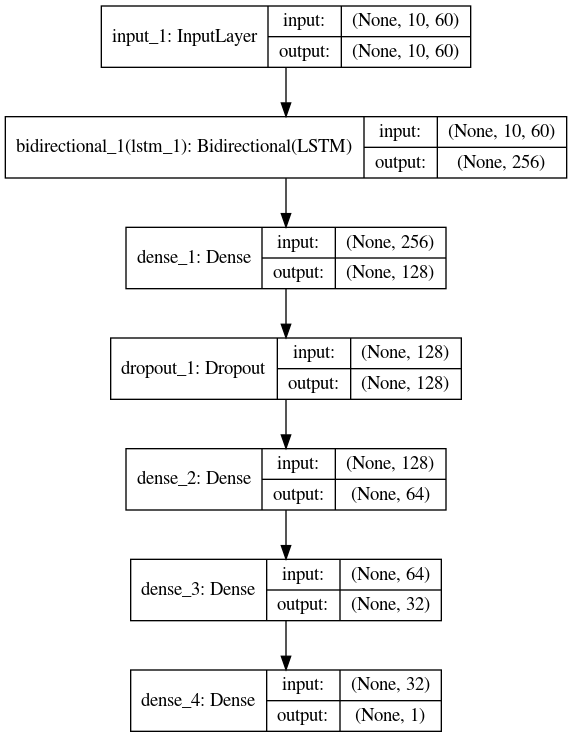

In [4]:
inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
lm1 = Bidirectional(LSTM(128, return_sequences=False))(inputs)
lm2 = Dense(128, activation='relu')(lm1)
drop1 = Dropout(0.2)(lm2)
lm3 = Dense(64, activation='relu')(drop1)
lm4 = Dense(32, activation='relu')(lm3)

outputs = Dense(1, activation='sigmoid')(lm4)

model = Model(inputs=inputs, outputs=outputs)

### Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)]

plot_model(model, to_file='model.png', show_shapes=True)

In [5]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256, 
         validation_data = (X_val,y_val)) 

Train on 213981 samples, validate on 52143 samples
Epoch 1/10
213981/213981 [==============================] - 71s 333us/step - loss: 0.5420 - accuracy: 0.6739 - val_loss: 0.3277 - val_accuracy: 0.8688
Epoch 2/10
213981/213981 [==============================] - 69s 321us/step - loss: 0.3104 - accuracy: 0.8774 - val_loss: 0.3119 - val_accuracy: 0.8738
Epoch 3/10
213981/213981 [==============================] - 67s 315us/step - loss: 0.2931 - accuracy: 0.8851 - val_loss: 0.2983 - val_accuracy: 0.8828
Epoch 4/10
213981/213981 [==============================] - 66s 308us/step - loss: 0.2840 - accuracy: 0.8896 - val_loss: 0.2921 - val_accuracy: 0.8851
Epoch 5/10
213981/213981 [==============================] - 68s 316us/step - loss: 0.2784 - accuracy: 0.8921 - val_loss: 0.2887 - val_accuracy: 0.8886
Epoch 6/10
213981/213981 [==============================] - 66s 308us/step - loss: 0.2738 - accuracy: 0.8937 - val_loss: 0.2853 - val_accuracy: 0.8891
Epoch 7/10
213981/213981 [=================

### Report performance

In [6]:
y_pred = model.predict(X_test) 
y_pred = (y_pred > 0.5).astype(int)
fullinfo_score = accuracy_score(y_pred,y_test)
fullinfo_score

0.8930098380057696

## 3.2 Without outcome and qualifiers
This model takes only data that was not censured by xPSG. It is what can be considered as my real attempt at the challenge.

In [7]:
X_train = np.load('article/x_train.npy')
y_train = np.load('article/y_train.npy')

X_test = np.load('article/x_test.npy')
y_test = np.load('article/y_test.npy')

X_val = np.load('article/x_val.npy')
y_val = np.load('article/y_val.npy')

X_train = np.delete(X_train, 0, 2)
X_train = np.delete(X_train, [2,3,4,5,6], 2)

X_test = np.delete(X_test, 0, 2)
X_test = np.delete(X_test, [2,3,4,5,6], 2)

X_val = np.delete(X_val, 0, 2)
X_val = np.delete(X_val, [2,3,4,5,6], 2)

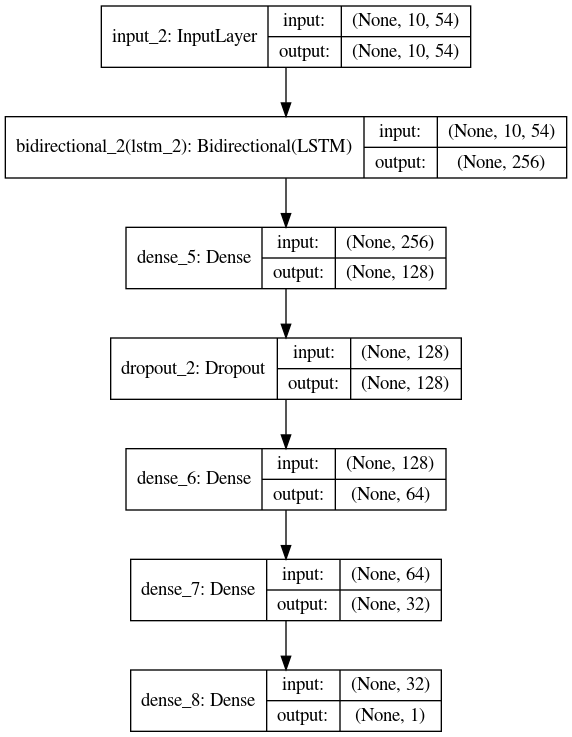

In [8]:
inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
lm1 = Bidirectional(LSTM(128, return_sequences=False))(inputs)
lm2 = Dense(128, activation='relu')(lm1)
drop1 = Dropout(0.2)(lm2)
lm3 = Dense(64, activation='relu')(drop1)
lm4 = Dense(32, activation='relu')(lm3)

outputs = Dense(1, activation='sigmoid')(lm4)

model = Model(inputs=inputs, outputs=outputs)

### Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)]

In [9]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256, 
         validation_data = (X_val,y_val)) 

Train on 213981 samples, validate on 52143 samples
Epoch 1/10
213981/213981 [==============================] - 66s 310us/step - loss: 0.6243 - accuracy: 0.6250 - val_loss: 0.5416 - val_accuracy: 0.7368
Epoch 2/10
213981/213981 [==============================] - 60s 281us/step - loss: 0.5156 - accuracy: 0.7513 - val_loss: 0.5157 - val_accuracy: 0.7457
Epoch 3/10
213981/213981 [==============================] - 55s 257us/step - loss: 0.4953 - accuracy: 0.7591 - val_loss: 0.5094 - val_accuracy: 0.7477
Epoch 4/10
213981/213981 [==============================] - 56s 262us/step - loss: 0.4868 - accuracy: 0.7645 - val_loss: 0.5043 - val_accuracy: 0.7526
Epoch 5/10
213981/213981 [==============================] - 55s 257us/step - loss: 0.4806 - accuracy: 0.7681 - val_loss: 0.5037 - val_accuracy: 0.7591
Epoch 6/10
213981/213981 [==============================] - 55s 258us/step - loss: 0.4762 - accuracy: 0.7709 - val_loss: 0.4989 - val_accuracy: 0.7598
Epoch 7/10
213981/213981 [=================

In [10]:
y_pred = model.predict(X_test) 
y_pred = (y_pred > 0.5).astype(int)
censured_score = accuracy_score(y_pred,y_test)
censured_score

0.7669946001923219

## 3.3 Baseline model: last team will be next team.
To have a baseline for my results, this is the simplest model: it predicts that the last team who did the event will be the next one.

In [11]:
y_pred_2 = X_test[:,9,2]
baseline_score = accuracy_score(y_pred_2,y_test)
baseline_score

0.6308158887491678

## 3.4 Results

In [36]:
results = {}
results['Random'], results['Last Team Next'], results['Censured Info'], results['Full Info'] = 0.5, baseline_score, censured_score, fullinfo_score
pd.DataFrame(results, index=['Score']).T.round(3)

,Score
Random,0.500
Last Team Next,0.631
Censured Info,0.767
Full Info,0.893


# Conclusion
As written earlier, I did not qualify for the final rounds. However, it is interesting to see the great accuracy that such models can achieve. More insights can be found in my blog post.